## Deep Computer Vision Using CNN

### Convolutions Tensorflow Implementation

Each image is represented as a 3D tensor of shape _[height, width, channels]_, a mini-batch is 4D tensor _[mini-batch size, height, width, channels]_. The weights of a convolutional layer are represented as a 4D tensor of shape $[f_h, f_n, f_{h'}, f_{n'}]$ and the bias term is a 1D tensor of shape $[f_n]$.

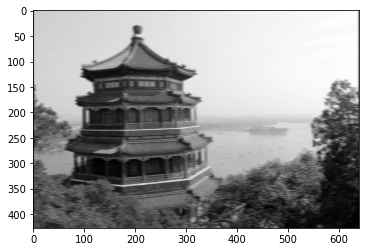

In [9]:
from sklearn.datasets import load_sample_image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
# filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical
filters[3, :, :, 1] = 1 # horizontal
# applying filters
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray")


__tf.nn.conv2d():__
- images is the input mini-batch (4D tensor)
- filters is the set of filters to apply (4D tensor)
- strides = 1, but it could be also a 1D array with four elements, the centrar elements are the vertical and horiontal strides ($s_h$ and $s_w$), and the first and last elements must currently be equal to 1. They may one day be used to specify a batch stride (to skip some instances) and a channel stride (skip some previous layer's feature maps)
- padding can be "SAME" or "VALID". "SAME" adds evenly zeros in order to have a rounded dimension for the stride, and "VALID" ignores some pixels.

<center><img src="img/padding.png"></img></center>

Normally, in a real CNN we define filters as trainable variables to let the NN figure out which filters work best. It is more useful _keras.layers.Conv2D_:

In [16]:
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                            padding="same", activation="relu", input_shape=outputs.shape)

In [17]:
conv_outputs = conv(images)
conv_outputs.shape
# [batch size, height, width, channels]

TensorShape([2, 427, 640, 2])

In [13]:
def crop(images):
    return images[150:220, 130:250]
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

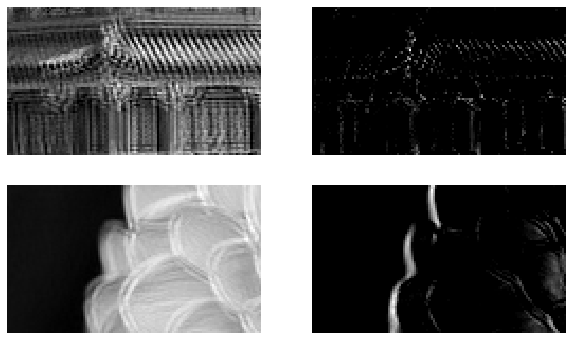

In [18]:
plt.figure(figsize=(10, 6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1) 
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))

### Pooling Tensorflow Implementation

Some things to keep in mind:
- Max pooling tend to be better tan average pooling, it introduces some level of invariance to small translations and rotations
- Max pooling preserves only the strongest features.
- Max pooling is destructive, an small 2x2 kernel with stride of 2 destroys almost 75% of the input values. 
- Invariance is not desired in semantic segmentation.

In [19]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [21]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

(-0.5, 59.5, 34.5, -0.5)

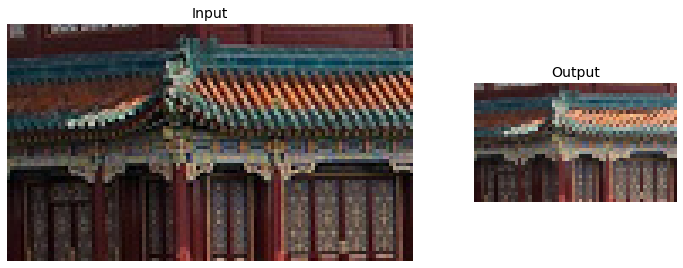

In [22]:
import matplotlib as mpl
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")

Pooling can be performed along the depth dimension rather than the spatial dimension, it is rare, but it can led the CNN to learn multiple filters, each detecting a different rotation, so it can be invariant to rotations, thickness, skew, color, etc.
<center><img src="img/depthwise.png"></img></center>

__Depthwise pooling layer__

In [ ]:
# TensorFlow's low-level DL API include a depthwise max pooling layer
output = tf.nn.max_pool(images,
                        ksize=(1, 1, 1, 3), # kernel size
                        strides=(1, 1, 1, 3),
                        padding="valid")
# The first 3 values of each tuple indicate that the kernel size and
# stride along the batch, height, and width dimensions should be 1.
# The last value should be whatever kernel size and stride we want
# along the depth dimension                    

In [ ]:
# Wrapping it in a Lambda Layer to add it to our model:
depth_pool = keras.layers.Lambda(
    lambda X: tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                             padding="valid")
)

__Global average pooling layer__

It is popular, but it is super destructive, it computes the mean of the whole feature map, so, its output is a single number per feature map.

In [ ]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avf_pool = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))

### CNN Arquitectures
<center><img src="img/cnn.png"></img></center>

A common mistake is to use convolution kernels that are to large, instead of using a 5x5 kernel, stack two layers with 3x3 kernels, fewer parameters, fewer computations and better performance. Only in the input layer is useful to have a large kernel.

In [24]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [25]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3,
                        activation="relu", padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation="softmax"),

])

In [27]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", 
                metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]
y_pred = model.predict(X_new)

2022-01-20 20:30:18.027009: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 172480000 exceeds 10% of free system memory.


Epoch 1/10
   1/1719 [..............................] - ETA: 1:30:23 - loss: 2.2919 - accuracy: 0.1875

2022-01-20 20:30:21.270651: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18063360 exceeds 10% of free system memory.
2022-01-20 20:30:21.314935: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 17160192 exceeds 10% of free system memory.
2022-01-20 20:30:21.315020: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 17160192 exceeds 10% of free system memory.


1719/1719 [==============================] - 440s 255ms/step - loss: 0.7069 - accuracy: 0.7558 - val_loss: 0.3805 - val_accuracy: 0.8660
Epoch 2/10
1719/1719 [==============================] - 421s 245ms/step - loss: 0.4165 - accuracy: 0.8613 - val_loss: 0.3100 - val_accuracy: 0.8850
Epoch 3/10
1719/1719 [==============================] - 416s 242ms/step - loss: 0.3603 - accuracy: 0.8792 - val_loss: 0.3064 - val_accuracy: 0.8870
Epoch 4/10
1719/1719 [==============================] - 412s 240ms/step - loss: 0.3279 - accuracy: 0.8889 - val_loss: 0.2929 - val_accuracy: 0.8906
Epoch 5/10
1719/1719 [==============================] - 408s 237ms/step - loss: 0.3099 - accuracy: 0.8971 - val_loss: 0.3028 - val_accuracy: 0.8958
Epoch 6/10
1719/1719 [==============================] - 409s 238ms/step - loss: 0.2974 - accuracy: 0.8996 - val_loss: 0.2906 - val_accuracy: 0.8946
Epoch 7/10
1719/1719 [==============================] - 411s 239ms/step - loss: 0.2793 - accuracy: 0.9055 - val_loss: 0.269